In [1]:
# Load the modules that are useful for solving this problem
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report as clt
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [4]:
# Load the data
my_data = pd.read_csv('SMS_train.csv', encoding = 'latin')
data_test = pd.read_csv('SMS_test.csv', encoding = 'latin')

In [5]:
# Overview the data
my_data.head(10)

,S. No.,Message_body,Label
0,1,Rofl. Its true to its name,Non-Spam
1,2,The guy did some bitching but I acted like i'd...,Non-Spam
2,3,"Pity, * was in mood for that. So...any other s...",Non-Spam
3,4,Will ü b going to esplanade fr home?,Non-Spam
4,5,This is the 2nd time we have tried 2 contact u...,Spam
5,6,REMINDER FROM O2: To get 2.50 pounds free call...,Spam
6,7,Huh y lei...,Non-Spam
7,8,Why don't you wait 'til at least wednesday to ...,Non-Spam
8,9,Ard 6 like dat lor.,Non-Spam
9,10,Ok lor... Sony ericsson salesman... I ask shuh...,Non-Spam


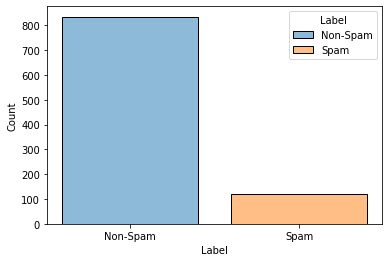

,S. No.,Message_body
Label,,
Non-Spam,835,835
Spam,122,122


In [6]:
# Measure the number of each class
sns.histplot(x = my_data['Label'], hue = my_data['Label'], shrink = 0.8)
plt.show()
my_data.groupby('Label').count()

In [7]:
# Measure 3 different dataset: imbalanced, oversampling, undersampling
data_ini = my_data.copy()

df1 = my_data.query("Label == 'Spam'")
df2 = my_data.query("Label == 'Non-Spam'")
indover = np.random.choice(df1.index, 835, replace = True)
dfover = my_data.iloc[indover]
indunder = np.random.choice(df2.index, 122, replace = False)
dfunder = my_data.iloc[indunder]

data_over = pd.concat([df2, dfover], axis = 0, ignore_index = True)
data_under = pd.concat([df1, dfunder], axis = 0, ignore_index = True)

In [8]:
# Word Embedding Function


nlp = spacy.load("en_core_web_lg", disable = ["parser", "ner"])

class PairedSentenceVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    # Vectorize a single sentence.
    def _transform1(self, sentence):
        
        words = sentence.split()
        vectors = np.zeros(nlp.vocab.vectors.shape[1])
        for i in words:
            vectors = vectors + nlp.vocab[i].vector
        return vectors

    # Vectorize a single row of the dataframe.
    def _transform2(self, row):

        vector1 = np.zeros(nlp.vocab.vectors.shape[1])
        vector1[0 : nlp.vocab.vectors.shape[1]] = self._transform1(row[2])
        return vector1

    def transform(self, X):
        return np.concatenate(
            [self._transform2(row).reshape(1, -1) for row in X.itertuples()])

In [9]:
# Method 1 Logistic Regression, Tf-idf to determine the best parameters, original dataset

def my_lr(data1, data2):
    pipe_1 = Pipeline(
        [('tfidf', TfidfVectorizer()),
         ('lr', LogisticRegression())])

    param_1 = {
        'tfidf__binary': (True, False),
        'tfidf__ngram_range': ((1, 1), (1, 2)),
        'lr__solver': ('newton-cg', 'lbfgs'),
        'lr__C': (1, 3)}

    grid_1 = GridSearchCV(pipe_1, param_1, cv = 5, verbose = 0, n_jobs = -1)
    grid_1.fit(data1['Message_body'], data1['Label'])
    test = grid_1.predict(X = data2['Message_body'])

    print("The best model :")
    print(grid_1.best_params_)
    print("The result :")
    print(clt(y_true = data2['Label'], y_pred = test))

In [ ]:
my_lr(data_ini, data_test)

The best model :
{'lr__C': 3, 'lr__solver': 'newton-cg', 'tfidf__binary': True, 'tfidf__ngram_range': (1, 1)}
The result :
              precision    recall  f1-score   support

    Non-Spam       0.65      1.00      0.79        49
        Spam       1.00      0.66      0.79        76

    accuracy                           0.79       125
   macro avg       0.83      0.83      0.79       125
weighted avg       0.86      0.79      0.79       125



In [ ]:
# Method 1 Logistic Regression, Tf-idf, best parameters

def my_lr_best(data1, data2):
    tfidfvec = TfidfVectorizer(binary = True)
    logr = LogisticRegression(C = 3, solver = 'newton-cg')
    
    pipe = Pipeline(
        [('tfidf', tfidfvec),
         ('lr', logr)])
    pipe.fit(data1['Message_body'], data1['Label'])
    test= pipe.predict(X = data2['Message_body'])
    
    print("The result :")
    print(clt(y_true = data2['Label'], y_pred = test))

In [ ]:
# Method 1 Logistic Regression, Tf-idf, best parameters, oversampling dataset
my_lr_best(data_over, data_test)

The result :
              precision    recall  f1-score   support

    Non-Spam       0.81      0.96      0.88        49
        Spam       0.97      0.86      0.91        76

    accuracy                           0.90       125
   macro avg       0.89      0.91      0.89       125
weighted avg       0.91      0.90      0.90       125



In [ ]:
# Method 1 Logistic Regression, Tf-idf, best parameters, undersampling dataset
my_lr_best(data_under, data_test)

The result :
              precision    recall  f1-score   support

    Non-Spam       0.92      0.96      0.94        49
        Spam       0.97      0.95      0.96        76

    accuracy                           0.95       125
   macro avg       0.95      0.95      0.95       125
weighted avg       0.95      0.95      0.95       125



In [ ]:
# Method 1 Logistic Regression : words embedding to determine the best parameters, 
# original dataset

def my_lr_em(data1, data2):
    psv = PairedSentenceVectorizer()
    x_em1 = psv.fit_transform(data1)
    x_em2 = psv.fit_transform(data2)
    pipe_1 = Pipeline(
        [('lr', LogisticRegression(max_iter = 200))])

    param_1 = {
        'lr__solver': ('newton-cg', 'lbfgs'),
        'lr__C': (0.1, 1)}

    grid_1 = GridSearchCV(pipe_1, param_1, cv = 5, verbose = 0, n_jobs = -1)
    grid_1.fit(x_em1, data1['Label'])
    test = grid_1.predict(X = x_em2)

    print("The best model :")
    print(grid_1.best_params_)
    print("The result :")
    print(clt(y_true = data2['Label'], y_pred = test))

In [ ]:
my_lr_em(data_ini, data_test)

The best model :
{'lr__C': 0.1, 'lr__solver': 'newton-cg'}
The result :
              precision    recall  f1-score   support

    Non-Spam       0.79      1.00      0.88        49
        Spam       1.00      0.83      0.91        76

    accuracy                           0.90       125
   macro avg       0.90      0.91      0.89       125
weighted avg       0.92      0.90      0.90       125



In [ ]:
# Method 1 Logistic Regression, wrod embedding, best parameters

def my_lr_em_best(data1, data2):
    psv = PairedSentenceVectorizer()
    x_em1 = psv.fit_transform(data1)
    x_em2 = psv.fit_transform(data2)
    logr = LogisticRegression(C = 0.1, solver = 'newton-cg', max_iter = 500)
    pipe = Pipeline([('lr', logr)])
    pipe.fit(x_em1, data1['Label'])
    test= pipe.predict(X = x_em2)
    
    print("The result :")
    print(clt(y_true = data2['Label'], y_pred = test))

In [ ]:
# Method 1 Logistic Regression, word embedding, best parameters, oversampling dataset
my_lr_em_best(data_over, data_test)

The result :
              precision    recall  f1-score   support

    Non-Spam       0.83      1.00      0.91        49
        Spam       1.00      0.87      0.93        76

    accuracy                           0.92       125
   macro avg       0.92      0.93      0.92       125
weighted avg       0.93      0.92      0.92       125



In [ ]:
# Method 1 Logistic Regression, word embedding, best parameters, undersampling dataset
my_lr_em_best(data_under, data_test)

The result :
              precision    recall  f1-score   support

    Non-Spam       0.87      0.98      0.92        49
        Spam       0.99      0.91      0.95        76

    accuracy                           0.94       125
   macro avg       0.93      0.94      0.93       125
weighted avg       0.94      0.94      0.94       125



In [ ]:
# Method 2 Support Vector Machine, Tf-idf to determine best parameters, original dataset

def my_svm(data1, data2):
    pipe_1 = Pipeline(
        [('tfidf', TfidfVectorizer()),
         ('svm', LinearSVC())])

    param_1 = {
        'tfidf__binary': (True, False),
        'tfidf__ngram_range': ((1, 1), (1, 2)),
        'svm__loss': ('hinge', 'squared_hinge'),
        'svm__C' : (1, 3)}

    grid_1 = GridSearchCV(pipe_1, param_1, cv = 5, verbose = 0, n_jobs = -1)
    grid_1.fit(data1['Message_body'], data1['Label'])
    test = grid_1.predict(X = data2['Message_body'])

    print("The best model :")
    print(grid_1.best_params_)
    print("The result :")
    print(clt(y_true = data2['Label'], y_pred = test))

In [ ]:
my_svm(data_ini, data_test)

The best model :
{'svm__C': 3, 'svm__loss': 'hinge', 'tfidf__binary': True, 'tfidf__ngram_range': (1, 2)}
The result :
              precision    recall  f1-score   support

    Non-Spam       0.83      1.00      0.91        49
        Spam       1.00      0.87      0.93        76

    accuracy                           0.92       125
   macro avg       0.92      0.93      0.92       125
weighted avg       0.93      0.92      0.92       125



In [ ]:
# Method 2 Support Vector Machine, Tf-idf, best parameters

def my_svm_best(data1, data2):
    
    tfidfvec = TfidfVectorizer(binary = True, ngram_range = (1, 2))
    lsvm = LinearSVC(C = 3, loss = 'hinge')
    
    pipe = Pipeline(
        [('tfidf', tfidfvec),
         ('svm', lsvm)])
    pipe.fit(data1['Message_body'], data1['Label'])
    test= pipe.predict(X = data2['Message_body'])
    
    print("The result :")
    print(clt(y_true = data2['Label'], y_pred = test))

In [ ]:
# Method 2 Support Vector Machine, Tf-idf, best parameters, oversampling dataset

my_svm_best(data_over, data_test)

The result :
              precision    recall  f1-score   support

    Non-Spam       0.80      1.00      0.89        49
        Spam       1.00      0.84      0.91        76

    accuracy                           0.90       125
   macro avg       0.90      0.92      0.90       125
weighted avg       0.92      0.90      0.91       125



In [ ]:
# Method 2 Support Vector Machine, Tf-idf, best parameters, undersampling dataset
my_svm_best(data_under, data_test)

The result :
              precision    recall  f1-score   support

    Non-Spam       0.94      0.96      0.95        49
        Spam       0.97      0.96      0.97        76

    accuracy                           0.96       125
   macro avg       0.96      0.96      0.96       125
weighted avg       0.96      0.96      0.96       125



In [ ]:
# Method 2 Support Vector Machine : words embedding, best parameters, original dataset 

def my_svm_em(data1, data2):
    psv = PairedSentenceVectorizer()
    x_em1 = psv.fit_transform(data1)
    x_em2 = psv.fit_transform(data2)
    pipe_1 = Pipeline([('svm', LinearSVC(max_iter = 6000))])

    param_1 = {
        'svm__loss': ('hinge', 'squared_hinge'),
        'svm__C' : (0.1, 1)}

    grid_1 = GridSearchCV(pipe_1, param_1, cv = 5, verbose = 0, n_jobs = -1)
    grid_1.fit(x_em1, data1['Label'])
    test = grid_1.predict(X = x_em2)

    print("The best model :")
    print(grid_1.best_params_)
    print("The result :")
    print(clt(y_true = data2['Label'], y_pred = test))

In [ ]:
my_svm_em(data_ini, data_test)

The best model :
{'svm__C': 0.1, 'svm__loss': 'hinge'}
The result :
              precision    recall  f1-score   support

    Non-Spam       0.76      0.98      0.86        49
        Spam       0.98      0.80      0.88        76

    accuracy                           0.87       125
   macro avg       0.87      0.89      0.87       125
weighted avg       0.90      0.87      0.87       125



In [ ]:
# Method 2 Support Vector Machine : words embedding, best parameters
def my_svm_em_best(data1, data2):
    psv = PairedSentenceVectorizer()
    x_em1 = psv.fit_transform(data1)
    x_em2 = psv.fit_transform(data2)
    lsvm = LinearSVC(C = 0.1, loss = 'hinge', max_iter = 5000)
    pipe = Pipeline([('svm', lsvm)])
    pipe.fit(x_em1, data1['Label'])
    test= pipe.predict(X = x_em2)
    
    print("The result :")
    print(clt(y_true = data2['Label'], y_pred = test))

In [ ]:
# Method 2 Support Vector Machine, word embedding, best parameters, oversampling dataset
my_svm_em_best(data_over, data_test)

The result :
              precision    recall  f1-score   support

    Non-Spam       0.79      0.98      0.87        49
        Spam       0.98      0.83      0.90        76

    accuracy                           0.89       125
   macro avg       0.89      0.90      0.89       125
weighted avg       0.91      0.89      0.89       125



In [ ]:
# Method 2 Support Vector Machine, word embedding, best parameters, undersampling dataset
my_svm_em_best(data_under, data_test)

The result :
              precision    recall  f1-score   support

    Non-Spam       0.85      0.94      0.89        49
        Spam       0.96      0.89      0.93        76

    accuracy                           0.91       125
   macro avg       0.90      0.92      0.91       125
weighted avg       0.92      0.91      0.91       125



In [ ]:
# Method 3 Random Forest : Tf-idf to determine best parameters, original dataset

def my_rf(data1, data2):
    pipe_1 = Pipeline(
        [('tfidf', TfidfVectorizer()),
         ('rf', RandomForestClassifier())])

    param_1 = {
        'tfidf__binary': (True, False),
        'tfidf__ngram_range': ((1, 1), (1, 2)),
        'rf__max_features': ('sqrt', 'log2'),
        'rf__ccp_alpha' : (0.0, 0.5),
        'rf__random_state' : (0, 1)}

    grid_1 = GridSearchCV(pipe_1, param_1, cv = 5, verbose = 0, n_jobs = -1)
    grid_1.fit(data1['Message_body'], data1['Label'])
    test = grid_1.predict(X = data2['Message_body'])

    print("The best model :")
    print(grid_1.best_params_)
    print("The result :")
    print(clt(y_true = data2['Label'], y_pred = test))

In [ ]:
my_rf(data_ini, data_test)

The best model :
{'rf__ccp_alpha': 0.0, 'rf__max_features': 'sqrt', 'rf__random_state': 0, 'tfidf__binary': True, 'tfidf__ngram_range': (1, 1)}
The result :
              precision    recall  f1-score   support

    Non-Spam       0.69      1.00      0.82        49
        Spam       1.00      0.71      0.83        76

    accuracy                           0.82       125
   macro avg       0.85      0.86      0.82       125
weighted avg       0.88      0.82      0.83       125



In [ ]:
# Method 3 Random Forest : Tf-idf， best parameters

def my_rf_best(data1, data2):
    
    tfidfvec = TfidfVectorizer(binary = True, ngram_range = (1, 1))
    rdf = RandomForestClassifier(ccp_alpha = 0.0, max_features = 'sqrt', random_state = 0)
    
    pipe = Pipeline(
        [('tfidf', tfidfvec),
         ('rf', rdf)])
    pipe.fit(data1['Message_body'], data1['Label'])
    test= pipe.predict(X = data2['Message_body'])
    
    print("The result :")
    print(clt(y_true = data2['Label'], y_pred = test))

In [ ]:
# Method 3 Random Forest : Tf-idf， best parameters, oversampling

my_rf_best(data_over, data_test)

The result :
              precision    recall  f1-score   support

    Non-Spam       0.69      1.00      0.82        49
        Spam       1.00      0.71      0.83        76

    accuracy                           0.82       125
   macro avg       0.85      0.86      0.82       125
weighted avg       0.88      0.82      0.83       125



In [ ]:
## Method 3 Random Forest : Tf-idf， best parameters, undersampling

my_rf_best(data_under, data_test)

The result :
              precision    recall  f1-score   support

    Non-Spam       0.75      1.00      0.86        49
        Spam       1.00      0.79      0.88        76

    accuracy                           0.87       125
   macro avg       0.88      0.89      0.87       125
weighted avg       0.90      0.87      0.87       125



In [ ]:
# Method 3 Random Forest : words embedding, best parameters, original dataset 

def my_rf_em(data1, data2):
    psv = PairedSentenceVectorizer()
    x_em1 = psv.fit_transform(data1)
    x_em2 = psv.fit_transform(data2)
    pipe_1 = Pipeline([('rf', RandomForestClassifier())])

    param_1 = {
        'rf__max_features': ('sqrt', 'log2'),
        'rf__ccp_alpha' : (0.0, 0.5),
        'rf__random_state' : (1, 2)}

    grid_1 = GridSearchCV(pipe_1, param_1, cv = 5, verbose = 0, n_jobs = -1)
    grid_1.fit(x_em1, data1['Label'])
    test = grid_1.predict(X = x_em2)

    print("The best model :")
    print(grid_1.best_params_)
    print("The result :")
    print(clt(y_true = data2['Label'], y_pred = test))

In [ ]:
my_rf_em(data_ini, data_test)

The best model :
{'rf__ccp_alpha': 0.0, 'rf__max_features': 'sqrt', 'rf__random_state': 2}
The result :
              precision    recall  f1-score   support

    Non-Spam       0.69      1.00      0.82        49
        Spam       1.00      0.71      0.83        76

    accuracy                           0.82       125
   macro avg       0.85      0.86      0.82       125
weighted avg       0.88      0.82      0.83       125



In [ ]:
# Method 3 Random Forest : words embedding, best parameters
def my_rf_em_best(data1, data2):
    psv = PairedSentenceVectorizer()
    x_em1 = psv.fit_transform(data1)
    x_em2 = psv.fit_transform(data2)
    rdf = RandomForestClassifier(ccp_alpha = 0.0, max_features = 'sqrt', random_state = 2)
    pipe = Pipeline([('rf', rdf)])
    pipe.fit(x_em1, data1['Label'])
    test= pipe.predict(X = x_em2)
    
    print("The result :")
    print(clt(y_true = data2['Label'], y_pred = test))

In [ ]:
# Method 3 Random Forest, word embedding, best parameters, oversampling dataset
my_rf_em_best(data_over, data_test)

The result :
              precision    recall  f1-score   support

    Non-Spam       0.69      1.00      0.82        49
        Spam       1.00      0.71      0.83        76

    accuracy                           0.82       125
   macro avg       0.85      0.86      0.82       125
weighted avg       0.88      0.82      0.83       125



In [ ]:
# Method 3 Random Forest, word embedding, best parameters, undersampling dataset
my_rf_em_best(data_under, data_test)

The result :
              precision    recall  f1-score   support

    Non-Spam       0.90      0.96      0.93        49
        Spam       0.97      0.93      0.95        76

    accuracy                           0.94       125
   macro avg       0.94      0.95      0.94       125
weighted avg       0.95      0.94      0.94       125



In [11]:
# Method 4 RNN-LSTM : with pre_trained words embedding from spacy

import os
import warnings

# Ignore FutureWarning from numpy
warnings.simplefilter(action='ignore', category=FutureWarning)

import keras.backend as K
import tensorflow as tf

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

# Allow growth of GPU memory, otherwise it will always look like all the memory is being used
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True) 

In [12]:
def word_index(data):
    word_to_index = {}
    for sentence in data['Message_body']:
        for word in sentence.split():
            if word not in word_to_index:
                word_to_index[word] = len(word_to_index) + 1
    return word_to_index

In [13]:
def word_embedding(data):
    embedding_matrix = np.zeros((len(data) + 1, 300))
    for i, j in data.items():
        embedding_matrix[j] = nlp.vocab[i].vector
    return embedding_matrix

In [14]:
# Method 4 RNN-LSTM with original dataset
word_to_index_ini = word_index(data_ini)
matrix_weight = word_embedding(word_to_index_ini)

In [62]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

def encode(tagged_sentences, y, word_to_index):
    X = []
    for s in tagged_sentences:
        Xcurrent = []
        for p in s.split():
            if p in word_to_index.keys():
                Xcurrent.append(word_to_index[p])
            else:
                Xcurrent.append(0)
        X.append(Xcurrent)
    
    X = pad_sequences(X)
    Y = np.where(y == 'Spam', 1, 0)
    Y = to_categorical(Y, num_classes = 2)

    return X, Y


X, Y = encode(data_ini['Message_body'], data_ini['Label'], word_to_index_ini)
N, M = X.shape


In [63]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Flatten
from keras.optimizers import rmsprop_v2
from keras.optimizers import adam_v2
from keras.losses import categorical_crossentropy

embedding_dim = 300
hidden_dim = 100

model = Sequential()

model.add(Embedding(len(word_to_index_ini) + 1, embedding_dim, 
                    weights = [matrix_weight], trainable = False, 
                    input_length = M))
model.add(Bidirectional(LSTM(hidden_dim)))
model.add(Dense(2, activation = 'softmax'))

model.compile(optimizer = 'rmsprop', loss = categorical_crossentropy, metrics = ['acc'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 96, 300)           1458300   
                                                                 
 bidirectional_3 (Bidirectio  (None, 200)              320800    
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 2)                 402       
                                                                 
Total params: 1,779,502
Trainable params: 321,202
Non-trainable params: 1,458,300
_________________________________________________________________


In [64]:
P = int(0.7 * N)
X_val = X[P : ]
Y_val = Y[P: ]
X_train = X[0 : P]
Y_train = Y[0 : P]

batch_No = 10
epo_No = 10

history = model.fit(x = X_train, y = Y_train, batch_size = batch_No, 
                    epochs = epo_No, verbose = 1, validation_data = (X_val, Y_val))

Epoch 1/10
67/67 [==============================] - 16s 169ms/step - loss: 0.1751 - acc: 0.9402 - val_loss: 0.0929 - val_acc: 0.9722
Epoch 2/10
67/67 [==============================] - 10s 153ms/step - loss: 0.0887 - acc: 0.9791 - val_loss: 0.0992 - val_acc: 0.9653
Epoch 3/10
67/67 [==============================] - 11s 158ms/step - loss: 0.0572 - acc: 0.9806 - val_loss: 0.1054 - val_acc: 0.9688
Epoch 4/10
67/67 [==============================] - 11s 157ms/step - loss: 0.0340 - acc: 0.9940 - val_loss: 0.3723 - val_acc: 0.9340
Epoch 5/10
67/67 [==============================] - 10s 156ms/step - loss: 0.0305 - acc: 0.9910 - val_loss: 0.1135 - val_acc: 0.9722
Epoch 6/10
67/67 [==============================] - 10s 157ms/step - loss: 0.0308 - acc: 0.9910 - val_loss: 0.1084 - val_acc: 0.9757
Epoch 7/10
67/67 [==============================] - 10s 156ms/step - loss: 0.0167 - acc: 0.9985 - val_loss: 0.1480 - val_acc: 0.9722
Epoch 8/10
67/67 [==============================] - 10s 155ms/step - 

In [17]:
import matplotlib.pyplot as plt

def plot_results(history):
    
    val_loss = history.history['val_loss']
    acc = history.history['acc']
    loss = history.history['loss']
    val_acc = history.history['val_acc']
    
    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['Training','Validation'])

    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(acc)
    plt.plot(val_acc)
    plt.legend(['Training','Validation'])

    plt.show()

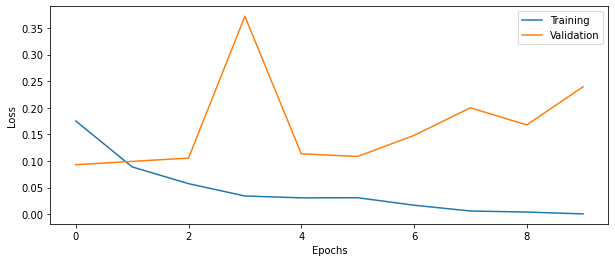

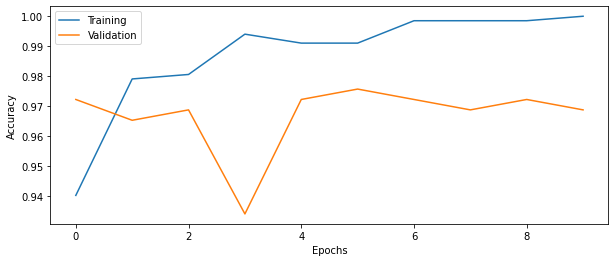

In [65]:
plot_results(history)

In [77]:
batch_No = 10
epo_No = 5

history = model.fit(x = X_train, y = Y_train, batch_size = batch_No, 
                    epochs = epo_No, verbose = 1, 
                    validation_data = (X_val, Y_val))

Epoch 1/5
67/67 [==============================] - 11s 157ms/step - loss: 5.3126e-06 - acc: 1.0000 - val_loss: 0.3933 - val_acc: 0.9722
Epoch 2/5
67/67 [==============================] - 10s 156ms/step - loss: 3.4640e-07 - acc: 1.0000 - val_loss: 0.3882 - val_acc: 0.9722
Epoch 3/5
67/67 [==============================] - 10s 156ms/step - loss: 2.6710e-07 - acc: 1.0000 - val_loss: 0.3653 - val_acc: 0.9722
Epoch 4/5
67/67 [==============================] - 11s 158ms/step - loss: 1.6055e-07 - acc: 1.0000 - val_loss: 0.3797 - val_acc: 0.9757
Epoch 5/5
67/67 [==============================] - 10s 156ms/step - loss: 8.3036e-08 - acc: 1.0000 - val_loss: 0.3837 - val_acc: 0.9757


In [78]:
X_test, Y_test = encode(data_test['Message_body'], data_test['Label'], word_to_index_ini)
X_test_1 = np.concatenate((X_test, np.zeros((125, 44))), axis = 1)
score = model.evaluate(X_test_1, Y_test, verbose = 0)

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

Test loss: 0.9669
Test accuracy: 0.9200


In [18]:
# Method 4 RNN-LSTM with undersampling dataset

word_to_index_under = word_index(data_under)
matrix_weight_under = word_embedding(word_to_index_under)
X_under, Y_under = encode(data_under['Message_body'], data_under['Label'], word_to_index_under)
N_under, M_under = X_under.shape


In [19]:
model_under = Sequential()

model_under.add(Embedding(len(word_to_index_under) + 1, embedding_dim, 
                    weights = [matrix_weight_under], trainable = False, 
                    input_length = M_under))
model_under.add(Bidirectional(LSTM(hidden_dim)))
model_under.add(Dense(2, activation = 'softmax'))

model_under.compile(optimizer = 'rmsprop', loss = categorical_crossentropy, metrics = ['acc'])

In [27]:
P_under = int(0.7 * N_under)
X_val_under = X_under[P_under : ]
Y_val_under = Y_under[P_under: ]
X_train_under = X_under[0 : P_under]
Y_train_under = Y_under[0 : P_under]

batch_No = 10
epo_No = 10

history_under = model_under.fit(x = X_train_under, y = Y_train_under, batch_size = batch_No, 
                    epochs = epo_No, verbose = 1, 
                    validation_data = (X_val_under, Y_val_under))

Epoch 1/10
17/17 [==============================] - 2s 95ms/step - loss: 0.0048 - acc: 1.0000 - val_loss: 0.0902 - val_acc: 0.9730
Epoch 2/10
17/17 [==============================] - 2s 91ms/step - loss: 0.0052 - acc: 1.0000 - val_loss: 0.1213 - val_acc: 0.9595
Epoch 3/10
17/17 [==============================] - 2s 90ms/step - loss: 0.0037 - acc: 1.0000 - val_loss: 0.1334 - val_acc: 0.9459
Epoch 4/10
17/17 [==============================] - 1s 89ms/step - loss: 0.0027 - acc: 1.0000 - val_loss: 0.1260 - val_acc: 0.9459
Epoch 5/10
17/17 [==============================] - 1s 88ms/step - loss: 0.0741 - acc: 0.9882 - val_loss: 0.1233 - val_acc: 0.9595
Epoch 6/10
17/17 [==============================] - 1s 89ms/step - loss: 0.0023 - acc: 1.0000 - val_loss: 0.1414 - val_acc: 0.9730
Epoch 7/10
17/17 [==============================] - 2s 89ms/step - loss: 0.0015 - acc: 1.0000 - val_loss: 0.1045 - val_acc: 0.9730
Epoch 8/10
17/17 [==============================] - 2s 93ms/step - loss: 0.0013 - a

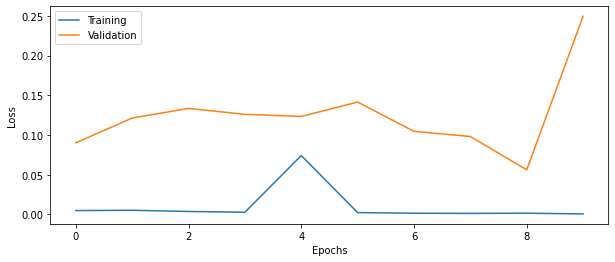

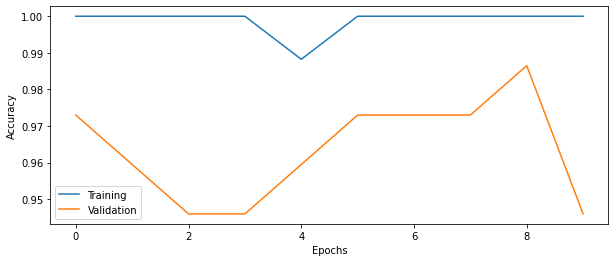

In [28]:
plot_results(history_under)

In [32]:
batch_No = 10
epo_No = 8

model_under.fit(x = X_train_under, y = Y_train_under, batch_size = batch_No, 
                    epochs = epo_No, verbose = 1, 
                    validation_data = (X_val_under, Y_val_under))

Epoch 1/8
17/17 [==============================] - 2s 101ms/step - loss: 0.0029 - acc: 1.0000 - val_loss: 0.1888 - val_acc: 0.9459
Epoch 2/8
17/17 [==============================] - 2s 91ms/step - loss: 4.6525e-04 - acc: 1.0000 - val_loss: 0.1516 - val_acc: 0.9459
Epoch 3/8
17/17 [==============================] - 2s 91ms/step - loss: 2.9108e-04 - acc: 1.0000 - val_loss: 0.1002 - val_acc: 0.9730
Epoch 4/8
17/17 [==============================] - 2s 93ms/step - loss: 2.7945e-04 - acc: 1.0000 - val_loss: 0.0711 - val_acc: 0.9865
Epoch 5/8
17/17 [==============================] - 2s 92ms/step - loss: 1.7072e-04 - acc: 1.0000 - val_loss: 0.3662 - val_acc: 0.9459
Epoch 6/8
17/17 [==============================] - 1s 89ms/step - loss: 6.6754e-05 - acc: 1.0000 - val_loss: 0.2804 - val_acc: 0.9459
Epoch 7/8
17/17 [==============================] - 1s 87ms/step - loss: 1.7313e-05 - acc: 1.0000 - val_loss: 0.2052 - val_acc: 0.9595
Epoch 8/8
17/17 [==============================] - 1s 87ms/step -

In [33]:
X_test, Y_test = encode(data_test['Message_body'], data_test['Label'], word_to_index_under)
X_test_under = np.concatenate((X_test, np.zeros((125, 9))), axis = 1)
score_under = model_under.evaluate(X_test_under, Y_test, verbose = 0)

print('Test loss: %.4f' % score_under[0])
print('Test accuracy: %.4f' % score_under[1])

Test loss: 0.3748
Test accuracy: 0.9600


In [79]:
# Method 4 RNN-LSTM with oversampling dataset

word_to_index_over = word_index(data_over)
matrix_weight_over = word_embedding(word_to_index_over)
X_over, Y_over = encode(data_over['Message_body'], data_over['Label'], word_to_index_over)
N_over, M_over = X_over.shape

In [80]:
model_over = Sequential()

model_over.add(Embedding(len(word_to_index_over) + 1, embedding_dim, 
                    weights = [matrix_weight_over], trainable = False, 
                    input_length = M_over))
model_over.add(Bidirectional(LSTM(hidden_dim)))
model_over.add(Dense(2, activation = 'softmax'))

model_over.compile(optimizer = 'rmsprop', loss = categorical_crossentropy, metrics = ['acc'])

In [81]:
P_over = int(0.7 * N_over)
X_val_over = X_over[P_over : ]
Y_val_over = Y_over[P_over: ]
X_train_over = X_over[0 : P_over]
Y_train_over = Y_over[0 : P_over]

batch_No = 10
epo_No = 10

history_over = model_over.fit(x = X_train_over, y = Y_train_over, batch_size = batch_No, 
                    epochs = epo_No, verbose = 1, 
                    validation_data = (X_val_over, Y_val_over))

Epoch 1/10
117/117 [==============================] - 23s 162ms/step - loss: 0.1638 - acc: 0.9401 - val_loss: 0.0526 - val_acc: 0.9721
Epoch 2/10
117/117 [==============================] - 18s 152ms/step - loss: 0.0693 - acc: 0.9795 - val_loss: 0.2366 - val_acc: 0.9082
Epoch 3/10
117/117 [==============================] - 18s 151ms/step - loss: 0.0374 - acc: 0.9897 - val_loss: 0.0542 - val_acc: 0.9900
Epoch 4/10
117/117 [==============================] - 18s 150ms/step - loss: 0.0233 - acc: 0.9914 - val_loss: 0.0039 - val_acc: 1.0000
Epoch 5/10
117/117 [==============================] - 18s 156ms/step - loss: 0.0061 - acc: 0.9991 - val_loss: 2.6830e-04 - val_acc: 1.0000
Epoch 6/10
117/117 [==============================] - 18s 152ms/step - loss: 0.0229 - acc: 0.9966 - val_loss: 0.0019 - val_acc: 1.0000
Epoch 7/10
117/117 [==============================] - 18s 153ms/step - loss: 0.0061 - acc: 0.9983 - val_loss: 0.0136 - val_acc: 0.9820
Epoch 8/10
117/117 [==============================]

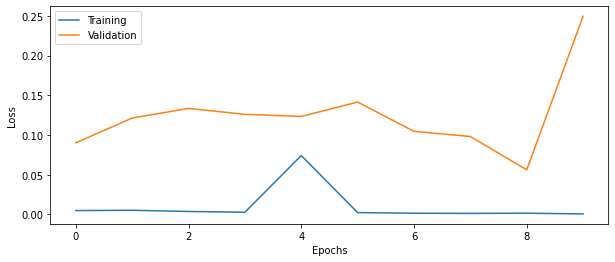

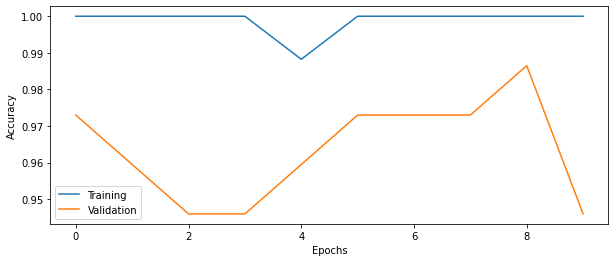

In [82]:
plot_results(history_under)

In [83]:
batch_No = 10
epo_No = 8

model_over.fit(x = X_train_over, y = Y_train_over, batch_size = batch_No, 
                    epochs = epo_No, verbose = 1, 
                    validation_data = (X_val_over, Y_val_over))

Epoch 1/8
117/117 [==============================] - 19s 159ms/step - loss: 0.0015 - acc: 0.9991 - val_loss: 0.2115 - val_acc: 0.9820
Epoch 2/8
117/117 [==============================] - 18s 156ms/step - loss: 3.0681e-06 - acc: 1.0000 - val_loss: 0.1815 - val_acc: 0.9820
Epoch 3/8
117/117 [==============================] - 18s 157ms/step - loss: 0.0077 - acc: 0.9991 - val_loss: 5.2347e-08 - val_acc: 1.0000
Epoch 4/8
117/117 [==============================] - 18s 154ms/step - loss: 0.0327 - acc: 0.9983 - val_loss: 4.5053e-06 - val_acc: 1.0000
Epoch 5/8
117/117 [==============================] - 18s 153ms/step - loss: 4.9773e-07 - acc: 1.0000 - val_loss: 2.7713e-06 - val_acc: 1.0000
Epoch 6/8
117/117 [==============================] - 18s 152ms/step - loss: 0.0184 - acc: 0.9966 - val_loss: 0.0887 - val_acc: 0.9820
Epoch 7/8
117/117 [==============================] - 18s 151ms/step - loss: 8.9304e-07 - acc: 1.0000 - val_loss: 0.0799 - val_acc: 0.9940
Epoch 8/8
117/117 [===================

In [84]:
X_test, Y_test = encode(data_test['Message_body'], data_test['Label'], word_to_index_over)
X_test_over = np.concatenate((X_test, np.zeros((125, 44))), axis = 1)
score_over = model_over.evaluate(X_test_over, Y_test, verbose = 0)

print('Test loss: %.4f' % score_over[0])
print('Test accuracy: %.4f' % score_over[1])

Test loss: 0.9282
Test accuracy: 0.9280
